# Notebook to view parsed data from sql database 
###Also view time-series variation in Monte-Carlo time

Author: Venkitesh Ayyar (vayyar@bu.edu) \
Nov 19, 2023

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sqlite3

import subprocess as sp
import os 
import glob
import pandas as pd
import itertools
import yaml
import sys

In [3]:
import gvar as gv

In [4]:
%matplotlib widget

In [5]:
from ipywidgets import *

In [6]:
sys.path.append('modules')
from modules_parse_hmc_Grid import *
from modules_plot import *
# from modules_measurement import *

## Read summary HMC data from table

In [7]:
### Read sql database
fname2='Stored_data/sql_dbase_files/summary_hmc_data.db'
conn = sqlite3.connect(fname2)
df_summary=pd.read_sql_query("SELECT * FROM summary",conn)


# # Convert strings to gvars for analysis
gvar_key_list=['plaq', 'sus_plaq', 'kurt_plaq', 'polyakov', 'sus_poly', 'kurt_poly', 'traj_time']
for key in gvar_key_list:        
#     df_summary[key] = df_summary[key].apply(lambda x: gv.gvar(x))
    df_summary[key] = df_summary[key].apply(lambda x: f_conv_strg_to_gvar(x))

In [8]:
df_summary.head()

,beta,mf,Lx,Lt,run_label,plaq,sus_plaq,kurt_plaq,plaq_autocorr,polyakov,sus_poly,kurt_poly,poly_autocorr,traj_time,accept,num_conf,run_key
0,10.0,0.1,16,8,cold-start,0.412963(77),0.00208(28),1.53(38)e-07,3,0.00389(20),0.0138(17),1.38(26)e-07,1,141.294(25),80.864198,172,beta-10.0_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start
1,10.0,0.1,16,8,hot-start,0.413407(61),0.00130(16),1.34(32)e-07,3,0.00356(18),0.0116(28),3.6(2.3)e-07,1,141.410(26),78.125000,170,beta-10.0_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start
2,10.2,0.1,16,8,cold-start,0.44180(10),0.00350(40),1.24(26)e-07,5,0.00362(18),0.0118(16),1.49(39)e-07,1,142.909(26),84.472050,172,beta-10.2_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start
3,10.2,0.1,16,8,hot-start,0.442028(92),0.00290(36),1.35(27)e-07,4,0.00336(18),0.0109(14),1.38(33)e-07,1,142.881(31),88.607595,168,beta-10.2_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start
4,10.4,0.1,16,8,cold-start,0.51540(10),0.00390(59),1.84(64)e-07,3,0.00365(18),0.0126(17),1.58(41)e-07,1,132.897(87),92.571429,186,beta-10.4_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start


## Summary analysis

In [19]:
df_sliced=df_summary.copy()

,beta,mf,Lx,Lt,run_label,plaq,sus_plaq,kurt_plaq,plaq_autocorr,polyakov,sus_poly,kurt_poly,poly_autocorr,traj_time,accept,num_conf,run_key
0,10.0,0.1,16,8,cold-start,0.412963(77),0.00208(28),1.53(38)e-07,3,0.00389(20),0.0138(17),1.38(26)e-07,1,141.294(25),80.864198,172,beta-10.0_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start
1,10.0,0.1,16,8,hot-start,0.413407(61),0.00130(16),1.34(32)e-07,3,0.00356(18),0.0116(28),3.6(2.3)e-07,1,141.410(26),78.125000,170,beta-10.0_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start
2,10.2,0.1,16,8,cold-start,0.44180(10),0.00350(40),1.24(26)e-07,5,0.00362(18),0.0118(16),1.49(39)e-07,1,142.909(26),84.472050,172,beta-10.2_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start
3,10.2,0.1,16,8,hot-start,0.442028(92),0.00290(36),1.35(27)e-07,4,0.00336(18),0.0109(14),1.38(33)e-07,1,142.881(31),88.607595,168,beta-10.2_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start
4,10.4,0.1,16,8,cold-start,0.51540(10),0.00390(59),1.84(64)e-07,3,0.00365(18),0.0126(17),1.58(41)e-07,1,132.897(87),92.571429,186,beta-10.4_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start


### Interactive plots full data

In [121]:
def f_plot_widgets(df_input,lx_list,lt_list,runlabel_list,mf_list,beta_list,obs,ylabel):
    '''
    Slice required rows using wigets and plot
    '''
    
    assert obs in df_sliced.columns.values
        
    df=df_input[(df_sliced.Lx.isin(lx_list))\
              & (df_sliced.Lt.isin(lt_list))\
              & (df_sliced.beta.isin(beta_list))\
              & (df_sliced.mf.isin(mf_list))\
              & (df_sliced.run_label.isin(runlabel_list))\
             ].reset_index(drop=True)

    f_plot_vary_beta(df,obs,ylabel)
    
# f_plot_widgets(df_sliced,lx_list[:],lt_list[:],runlabel_list[:],mf_list[:],beta_list[:],'plaq','y')

lx_list  =np.unique(df_sliced.Lx.values)
lt_list  =np.unique(df_sliced.Lt.values)
runlabel_list=np.unique(df_sliced.run_label.values)
mf_list=np.unique(df_sliced.mf.values)
beta_list=np.unique(df_sliced.beta.values)
output_columns=['plaq','sus_plaq','kurt_plaq','plaq_autocorr',\
               'polyakov','sus_poly','kurt_poly','poly_autocorr',\
               'traj_time','accept','num_conf']

lxs=widgets.SelectMultiple(options=lx_list,value=tuple(lx_list[:1]),description='Lx')
lts=widgets.SelectMultiple(options=lt_list,value=tuple(lt_list[:1]),description='Lt')
runlabels=widgets.SelectMultiple(options=runlabel_list,value=tuple(runlabel_list[:1]), description='run-label')
mfs=widgets.SelectMultiple(options=mf_list,value=tuple(mf_list[:1]),description='m_f')
betas=widgets.SelectMultiple(options=beta_list,value=tuple(beta_list[:1]), description='beta')
obs_w=widgets.Select(options=output_columns,description='observable')


v1=VBox([lxs,lts])
v2=VBox([runlabels,mfs])
v3=VBox([betas,obs_w])

ui=HBox(children=[v1,v2,v3])

out=interactive_output(f_plot_widgets, {'df_input':fixed(df_sliced),
            'lx_list': lxs,'lt_list':lts,'runlabel_list':runlabels,'mf_list':mfs,\
             'beta_list':betas, 'obs':obs_w,'ylabel':fixed('y')} )

display(out,ui)


Output()

In [ ]:
# df_sliced=df_summary[((df_summary.Lx==16)&(df_summary.Lt==8)&(df_summary.mf==0.1))|((df_summary.Lt==12)&(df_summary.mf==0.067))].copy()
# df_sliced=df_summary[((df_summary.Lx==24)&(df_summary.Lt==12)&(df_summary.mf==0.1))].copy()
# df_sliced=df_summary[((df_summary.Lx==16)&(df_summary.Lt==8)&(df_summary.mf==0.1))].copy()

df_sliced.head()

#### Number of configurations

,Lx,Lt,run_label,num_conf
beta,,,,
10.6,16,8,cold-start,1136
10.6,16,8,hot-start,970
10.8,16,8,cold-start,2396
10.8,16,8,hot-start,2586
11.0,16,8,cold-start,1564
11.0,16,8,hot-start,2140
11.2,16,8,hot-start,1654
11.4,16,8,hot-start,1834
11.6,16,8,hot-start,1642


Text(0, 0.5, 'MDTUs')

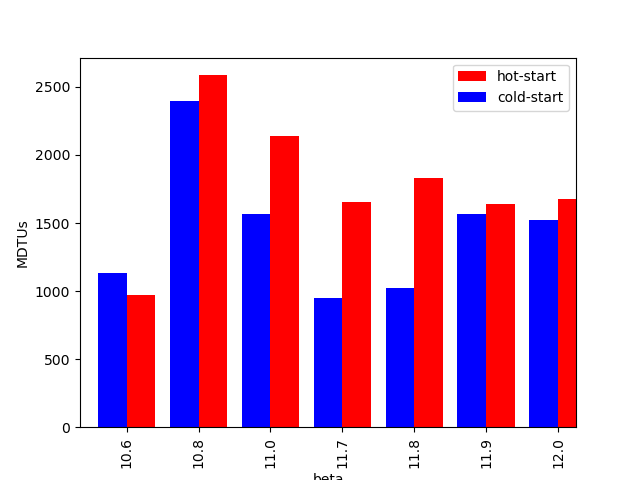

In [10]:
## Plot number of configs
df=df_sliced[(df_sliced.beta>10.5)&(df_sliced.beta<17.1)\
             &(df_sliced.Lx==16)&(df_sliced.Lt==8)&\
             (df_sliced.mf==0.1)]\
[['Lx','Lt','beta','run_label','num_conf']]
df.set_index('beta',inplace=True)

display(df)

width=0.4 

plt.figure()

label='hot-start'
df[df.run_label==label].num_conf.plot(kind='bar', width=width, color='red', position=0, label=label)

label='cold-start'
(df[df.run_label==label].num_conf).plot(kind='bar', width=width, color='blue', position=1, label=label)

plt.legend(loc='best')

plt.ylabel("MDTUs")
# plt.savefig('fig_output/num_confs_hot_cold.pdf')


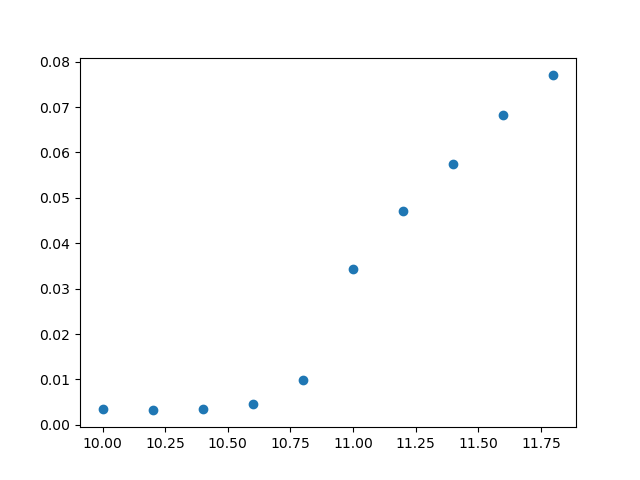

In [11]:
df=df_sliced[(((df_sliced.Lx==16)&(df_sliced.Lt==8))|((df_sliced.Lx==24)&(df_sliced.Lt==12)))\
             &(df_sliced.run_label=='hot-start')\
             &(df_sliced.mf==0.1)].reset_index(drop=True)


f_plot_vary_beta(df,'polyakov','Polyakov loop')
# f_plot_vary_beta(df,'plaq','Plaquette')
# f_plot_vary_beta(df,'sus_plaq','$\chi_{Plaquette}$')
# f_plot_vary_beta(df,'sus_poly','$\chi_{Polyakov}$')
# f_plot_vary_beta(df,'accept','Acceptance')

# f_plot_vary_beta(df,'traj_time','Traj time')

### Interactive plots specific runs

In [13]:
output_columns=['plaq','sus_plaq','kurt_plaq','plaq_autocorr',\
               'polyakov','sus_poly','kurt_poly','poly_autocorr',\
               'traj_time','accept','num_conf']

interact_manual(f_plot_vary_beta,df=fixed(df),obs=output_columns,ylabel=fixed('y'),op_fname=fixed(''))

interactive(children=(Dropdown(description='obs', options=('plaq', 'sus_plaq', 'kurt_plaq', 'plaq_autocorr', '…

<function modules_plot.f_plot_vary_beta(df, obs, ylabel='y', op_fname=0)>

## HMC time series behavior

In [14]:
def f_get_hmc_data(dict1,fname1):
    '''
    Given a dictionary, extract the time series for just that set of couplings
    '''

    sql_query='SELECT * FROM test \
    WHERE Lx={Lx} \
    AND Lt={Lt} \
    AND mf={mf} \
    AND beta IN {beta}\
    '.format(**dict1)
    
    print(sql_query)
    
    conn = sqlite3.connect(fname1)
    df_read=pd.read_sql_query(sql_query,conn)
    df_read['Polyakov']=df_read['Polyakov'].astype(np.complex128)
    conn.close()
    
    return df_read



fname1='Stored_data/sql_dbase_files/parsed_hmc.db'
dict1={'Lx':'16', 'Lt':'8','mf':'0.1',  'beta':'(10.4,10.6,10.8)' }
df_hmc=f_get_hmc_data(dict1,fname1)

SELECT * FROM test     WHERE Lx=16     AND Lt=8     AND mf=0.1     AND beta IN (10.4,10.6,10.8)    


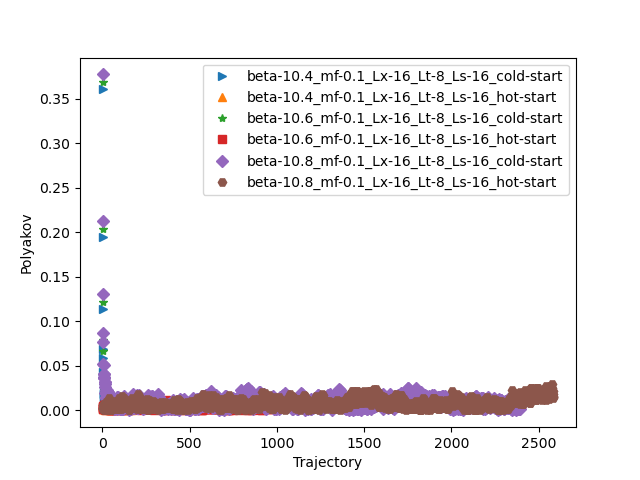

In [15]:
# f_plot_hmc_runs(df_hmc,'Plaquette')
# # plt.savefig('fig_output/Plaq_details.pdf')
f_plot_hmc_runs(df_hmc,'Polyakov')
# f_plot_hmc_runs(df_hmc,'Traj_time')
# f_plot_hmc_runs(df_hmc,'Accept')


### Interactive time-series plots

In [16]:

interact_manual(f_plot_hmc_runs,df_input=fixed(df_hmc),\
                column=['Plaquette','Polyakov','Traj_time','Accept'])

interactive(children=(Dropdown(description='column', options=('Plaquette', 'Polyakov', 'Traj_time', 'Accept'),…

<function modules_plot.f_plot_hmc_runs(df_input, column)>

### Polyakov loop details

SELECT * FROM test     WHERE Lx=16     AND Lt=8     AND mf=0.1     AND beta IN (10.4, 10.6, 11.8)    


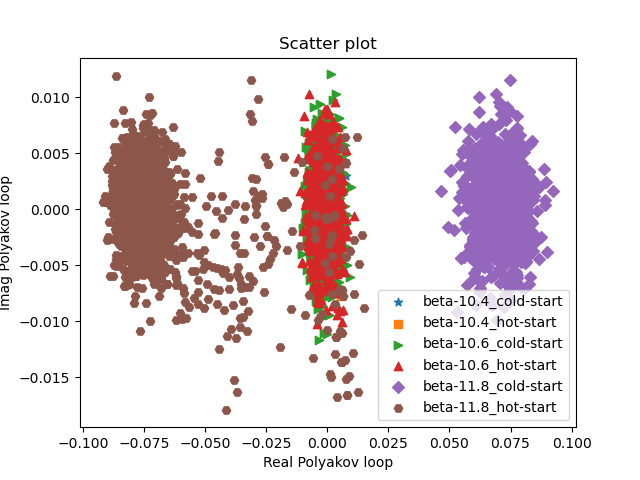

In [17]:

dict1={'Lx':'16', 'Lt':'8','mf':'0.1',  'beta':'(10.4, 10.6, 11.8)' }
df_hmc=f_get_hmc_data(dict1,fname1)

# df_hmc=df_hmc[df_hmc.run_label=='cold-start']

# f_ploop_histogram(df_hmc,100)
f_scatter_plot(df_hmc,50)

In [119]:
a = widgets.IntSlider(value=5, min=0, max=10)

def f1(a):
    display(a)
    
def f2(a):
    display(a * 2)
    
out1 = widgets.interactive_output(f1, {'a': a})
out2 = widgets.interactive_output(f2, {'a': a})

display(a)
display(out1)
display(out2)

IntSlider(value=5, max=10)

Output()

Output()